# CDE Hyperparameter Tuning with Optuna

In this notebook, we will use Optuna to tune the hyperparameters of a 
conditional density estimator (CDE). [Optuna](https://optuna.org/) is a 
framework-agnostic hyperparameter tuning package. Given a range of 
hyperparameters, it traverses this space in a smart way, exploring parameter
values that are more likely to maximize/minimize your objective. 

In this notebook, we will also take advantage of an early-stopping protocol, 
where Optuna looks at the validation loss at each epoch of network training and
stops the trial if it is unlikely to beat the best set of hyperparameters
found so far.

Before starting, please make sure you have `keras` and `optuna` installed
in your environment.
<!--- TODO: figure out what the requirement versions are --> 

In [2]:
import numpy as np
from sklearn.model_selection import train_test_split


import visual_bars.generate_visual_bars_data as vbd
from cfl.experiment import Experiment

import optuna
from optuna.integration import KerasPruningCallback
from optuna.trial import TrialState

from keras import Sequential
from keras.layers import Dense, Dropout
# TODO: install keras in requirements or instructions here

## Load Data
We will be using the visual bars example data for this tutorial. To learn 
more about this included dataset, please refer to the visual bars background
[page](https://cfl.readthedocs.io/en/latest/more_info/Visual_Bars_data.html).
If you would like to see a standard example of running CFL on this dataset
without hyperparameter tuning, please refer to the main CFL code 
[tutorial](https://cfl.readthedocs.io/en/latest/examples/cfl_code_intro.html).

Here, we create a dataset of 10000 samples, where the cause is a 10x10 image
and the effect is a binary 1D variable. For sake of simplicity, we will be
tuning a standard feed-forward network (as opposed to a convolutional 
neural network), so flatten the images down to vectors of shape (1,100). 

Since we want to evaluate our models on the same subset of the data across
all hyperparameter combinations, we generate in-sample and out-of-sample
indices to pass to CFL. If these are not provided, CFL generates this
split randomly, and it would look different across every trial. 

In [3]:
# create visual bars data 
n_samples = 20000 
im_shape = (10, 10) 
noise_lvl= 0.03
random_state = 180

vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape=im_shape, 
                             noise_lvl=noise_lvl, set_random_seed=random_state)

# retrieve the images and the target 
X = vb_data.getImages()
X = np.reshape(X, (X.shape[0], np.product(X.shape[1:]))) # flatten images
Y = vb_data.getTarget()
Y = np.expand_dims(Y, -1)
print(X.shape)
print(Y.shape)

# define train and validation sets to remain constant across tuning
in_sample_idx, out_sample_idx = train_test_split(range(X.shape[0]),
                                                 train_size=0.75,
                                                 random_state=42)

(20000, 100)
(20000, 1)


## Make a CDE network

Next, we need to outline the architecture of our neural network. We use
Optuna's `trial.suggest_xxx` methods to determine the number of layers, number
of units in each layer, and the amount of dropout after each layer in the
network. For more information on how to use Optuna to suggest hyperparameters,
please refer to their [documentation](https://optuna.org/).

In [4]:
def build_model(trial):
    
    # vary number of layers
    n_layers = trial.suggest_int("n_layers", 1, 5)
    model = Sequential()
    
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = trial.suggest_int("n_units_l{}".format(i), 4, 512, log=True)
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = trial.suggest_float("dropout_l{}".format(i), 0.0, 0.5)
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))

    return model

## Define the tuning objective

Optuna takes in an `objective` function to perform tuning over. An objective
function should, assuming some set of hyperparameters generated by the
current optuna trial, 1) build our model of interest, 2) run the model, and
3) evaluate the model and return some metric of how well it did.

Here, we define the parameters for a CFL Experiment that contains one Block - 
a CDE. Specifically, we use a 'CondExpDIY' CDE because 1) we want to estimate
the conditional expectation of P(Y|X) instead of the full distribution for
computational esse, and 2) we want to provide our own model (defined above) 
instead of using a pre-defined model that CFL supplies.

Note that some of the parameters in `CDE_params` ('lr' and 'batch_size') are 
also defined by Optuna `trial.suggest_xxx` methods and will be optimized in
the same way as the network architecutre parameters.

Lastly, once the CDE has been trained, we pull the final validation loss
from the packaged cfl results and return it as our evaluation of the current
set of hyperparameters.

In [5]:
def objective(trial):

    # define the parameters for a CFL Experiment
    data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

    CDE_params = {
        'model'           : 'CondExpDIY',
        'optuna_callback' : KerasPruningCallback(trial, "val_loss"),
        'optuna_trial'    : trial,
        'build_model'     : build_model,

        'lr'              : trial.suggest_float("lr", 1e-5, 1e-1, log=True),                
        'batch_size'      : trial.suggest_int("batch_size", 16, 128),
        'n_epochs'        : 100,
        'optimizer'       : 'adam',
        'loss'            : 'mean_squared_error',
        'best'            : True, 
        'verbose'         : 0,
        'early_stopping'  : True,
    }

    block_names = ['CondDensityEstimator']
    block_params = [CDE_params]

    my_exp = Experiment(X_train=X, 
                        Y_train=Y, 
                        in_sample_idx=in_sample_idx,
                        out_sample_idx=out_sample_idx,
                        data_info=data_info, 
                        block_names=block_names, 
                        block_params=block_params, 
                        verbose=0,
                        results_path=None) # we don't want to save 100's of results

    train_results = my_exp.train()     
    score = train_results['CondDensityEstimator']['val_loss'][-1]
    return score

## Run an Optuna study

Finally, we are ready to optimize our hyperparameters. We first create
a 'study' which will minimize the score returned by `objective` above, and
will prune training during trials where the validation loss isn't dropping
at a promising rate.

We call `study.optimize` to try 50 different samples of hyperparameters from
the space we described with the `trial.suggest_xxx` methods.

By setting `show_plot` to `True` in `CDE_params`, we can visualize how the 
loss varies across different hyperparameter combinations.

[I 2021-10-25 12:45:33,340] A new study created in memory with name: no-name-a3172352-9599-4456-a828-1ae2b1a376f5
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  


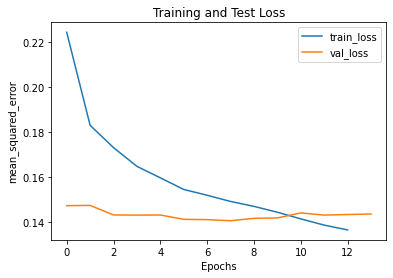

[I 2021-10-25 12:45:55,173] Trial 0 finished with value: 0.1434810547672212 and parameters: {'lr': 0.005790201825753634, 'batch_size': 119, 'n_layers': 3, 'n_units_l0': 261, 'dropout_l0': 0.07245778101580436, 'n_units_l1': 18, 'dropout_l1': 0.062332241984934145, 'n_units_l2': 36, 'dropout_l2': 0.47402789129245815}. Best is trial 0 with value: 0.1434810547672212.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  


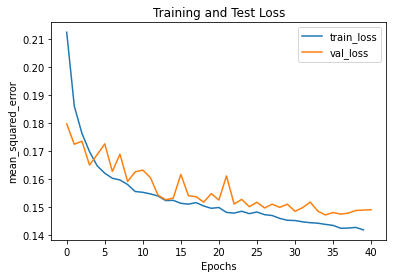

[I 2021-10-25 12:47:21,490] Trial 1 finished with value: 0.14911920533180237 and parameters: {'lr': 0.006118860550282907, 'batch_size': 91, 'n_layers': 4, 'n_units_l0': 71, 'dropout_l0': 0.4822160986148932, 'n_units_l1': 14, 'dropout_l1': 0.07610427295207384, 'n_units_l2': 351, 'dropout_l2': 0.22075325668106566, 'n_units_l3': 5, 'dropout_l3': 0.16268508601666648}. Best is trial 0 with value: 0.1434810547672212.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  


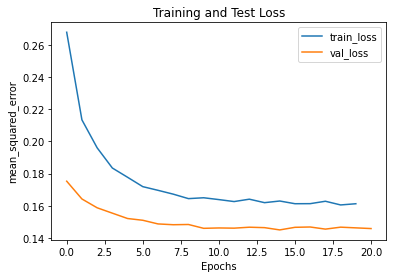

[I 2021-10-25 12:47:38,651] Trial 2 finished with value: 0.14586258927583695 and parameters: {'lr': 3.337968071029276e-05, 'batch_size': 72, 'n_layers': 2, 'n_units_l0': 4, 'dropout_l0': 0.008022164513548535, 'n_units_l1': 10, 'dropout_l1': 0.44008863181846014}. Best is trial 0 with value: 0.1434810547672212.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  


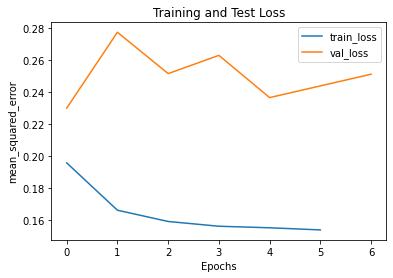

[I 2021-10-25 12:48:11,368] Trial 3 finished with value: 0.2511278108507395 and parameters: {'lr': 0.00011936366032040739, 'batch_size': 25, 'n_layers': 4, 'n_units_l0': 14, 'dropout_l0': 0.2739453727222328, 'n_units_l1': 322, 'dropout_l1': 0.28430732994828883, 'n_units_l2': 12, 'dropout_l2': 0.41116284825680327, 'n_units_l3': 176, 'dropout_l3': 0.26447627694689047}. Best is trial 0 with value: 0.1434810547672212.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  


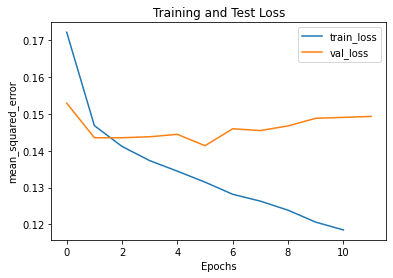

[I 2021-10-25 12:48:29,875] Trial 4 finished with value: 0.14934692753851414 and parameters: {'lr': 0.0005658253413500158, 'batch_size': 110, 'n_layers': 1, 'n_units_l0': 450, 'dropout_l0': 0.0846893995675051}. Best is trial 0 with value: 0.1434810547672212.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:48:35,841] Trial 5 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:48:42,963] Trial 6 pruned. Trial was pruned at epoch 0.


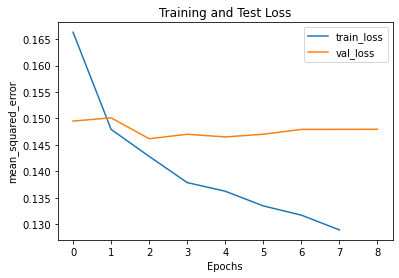

[I 2021-10-25 12:48:55,692] Trial 7 finished with value: 0.14795744597911833 and parameters: {'lr': 0.012340851032487672, 'batch_size': 108, 'n_layers': 1, 'n_units_l0': 267, 'dropout_l0': 0.13994802968130937}. Best is trial 0 with value: 0.1434810547672212.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:49:04,414] Trial 8 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:49:15,559] Trial 9 pruned. Trial was pruned at epoch 0.


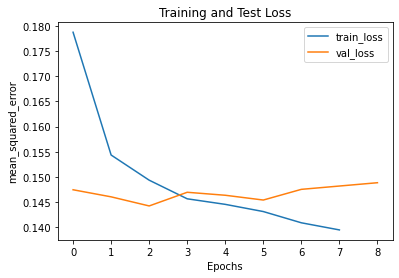

[I 2021-10-25 12:49:57,472] Trial 10 finished with value: 0.14886266532242298 and parameters: {'lr': 0.03832256266989998, 'batch_size': 29, 'n_layers': 2, 'n_units_l0': 118, 'dropout_l0': 0.17188833322538766, 'n_units_l1': 4, 'dropout_l1': 0.04928408801191347}. Best is trial 0 with value: 0.1434810547672212.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:50:04,885] Trial 11 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:50:09,923] Trial 12 prune

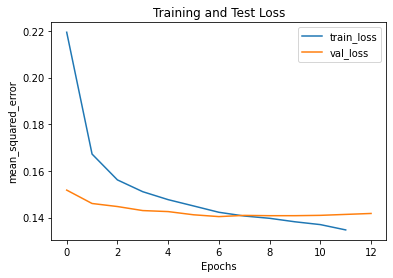

[I 2021-10-25 12:50:43,984] Trial 17 finished with value: 0.14179676063358784 and parameters: {'lr': 3.2388756913147233e-05, 'batch_size': 125, 'n_layers': 1, 'n_units_l0': 111, 'dropout_l0': 0.21541089400281782}. Best is trial 17 with value: 0.14179676063358784.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:50:49,709] Trial 18 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:50:57,675] Trial 19 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 

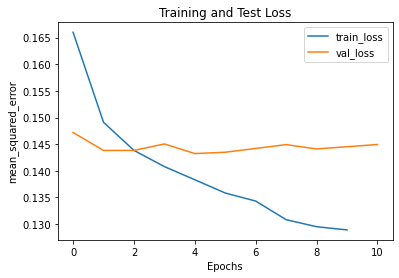

[I 2021-10-25 12:51:21,698] Trial 22 finished with value: 0.14493905338346957 and parameters: {'lr': 2.5288458446095748e-05, 'batch_size': 114, 'n_layers': 1, 'n_units_l0': 201, 'dropout_l0': 0.11576925592701436}. Best is trial 17 with value: 0.14179676063358784.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  


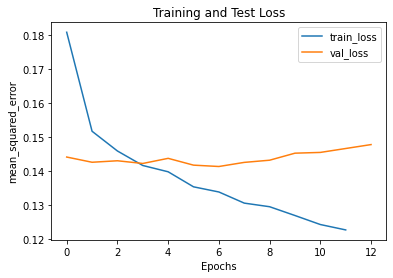

[I 2021-10-25 12:51:43,123] Trial 23 finished with value: 0.14782329207658768 and parameters: {'lr': 0.00010401252086203042, 'batch_size': 116, 'n_layers': 1, 'n_units_l0': 333, 'dropout_l0': 0.20111730566730365}. Best is trial 17 with value: 0.14179676063358784.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:51:48,968] Trial 24 pruned. Trial was pruned at epoch 1.


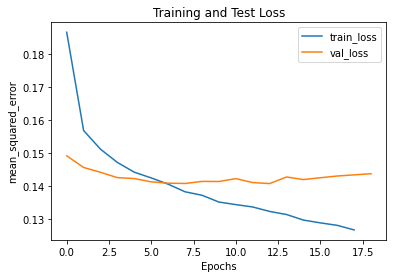

[I 2021-10-25 12:52:09,601] Trial 25 finished with value: 0.1436365840435028 and parameters: {'lr': 0.000150622351919751, 'batch_size': 120, 'n_layers': 1, 'n_units_l0': 90, 'dropout_l0': 0.106837003553691}. Best is trial 17 with value: 0.14179676063358784.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:52:17,247] Trial 26 pruned. Trial was pruned at epoch 0.


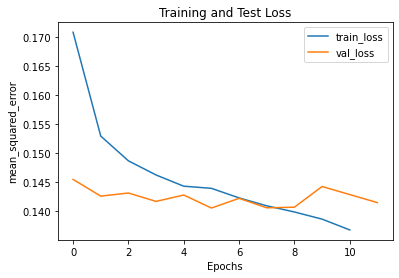

[I 2021-10-25 12:52:31,023] Trial 27 finished with value: 0.1414891245700419 and parameters: {'lr': 7.581461550434247e-05, 'batch_size': 119, 'n_layers': 2, 'n_units_l0': 87, 'dropout_l0': 0.2086136533918047, 'n_units_l1': 18, 'dropout_l1': 0.0030425153656810644}. Best is trial 27 with value: 0.1414891245700419.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:52:36,349] Trial 28 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:52:40,529] Trial 29 p

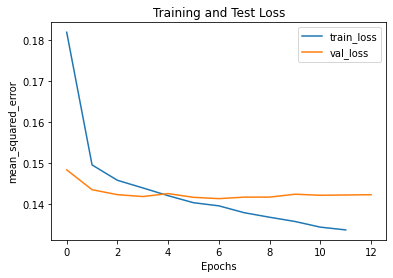

[I 2021-10-25 12:53:06,825] Trial 32 finished with value: 0.14224024908542632 and parameters: {'lr': 0.0003928643475155803, 'batch_size': 128, 'n_layers': 2, 'n_units_l0': 76, 'dropout_l0': 0.046579763007088715, 'n_units_l1': 6, 'dropout_l1': 0.0006282250781616261}. Best is trial 27 with value: 0.1414891245700419.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:53:15,941] Trial 33 pruned. Trial was pruned at epoch 5.
[I 2021-10-25 12:53:21,670] Trial 34

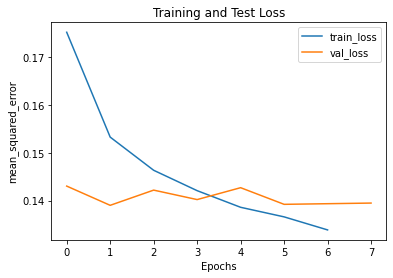

[I 2021-10-25 12:55:34,228] Trial 53 finished with value: 0.13949080734550953 and parameters: {'lr': 2.8557443159312392e-05, 'batch_size': 109, 'n_layers': 1, 'n_units_l0': 297, 'dropout_l0': 0.18001143042074452}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  


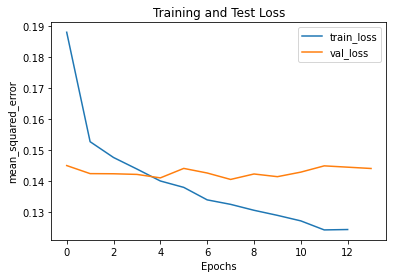

[I 2021-10-25 12:55:53,263] Trial 54 finished with value: 0.14413469689786435 and parameters: {'lr': 2.690104226080794e-05, 'batch_size': 109, 'n_layers': 1, 'n_units_l0': 304, 'dropout_l0': 0.24498989849035852}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:56:07,214] Trial 55 pruned. Trial was pruned at epoch 3.
[I 2021-10-25 12:56:12,844] Trial 56 pruned. Trial was pruned at epoch 0.


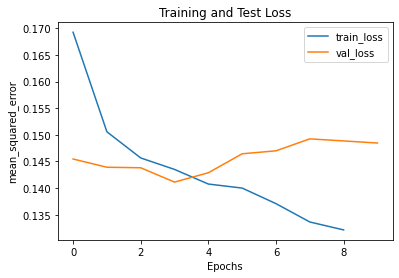

[I 2021-10-25 12:56:41,879] Trial 57 finished with value: 0.14846225099563598 and parameters: {'lr': 8.966879596711746e-05, 'batch_size': 128, 'n_layers': 2, 'n_units_l0': 502, 'dropout_l0': 0.22319948048338914, 'n_units_l1': 84, 'dropout_l1': 0.14572693619562957}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:56:53,719] Trial 58 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:56:59,418] Trial 59

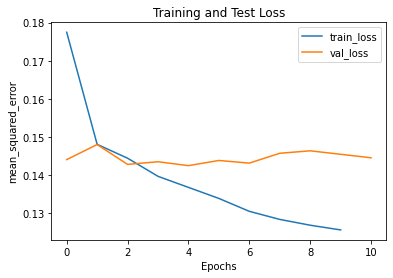

[I 2021-10-25 12:57:39,731] Trial 63 finished with value: 0.14455807987600566 and parameters: {'lr': 1.0577439097553174e-05, 'batch_size': 115, 'n_layers': 1, 'n_units_l0': 416, 'dropout_l0': 0.1888216167910452}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:57:47,527] Trial 64 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:57:53,936] Trial 65 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 1

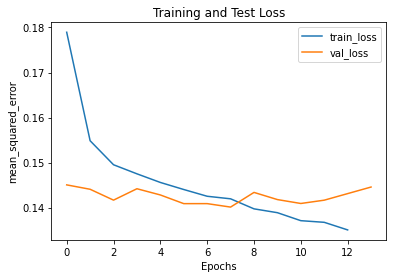

[I 2021-10-25 12:58:24,899] Trial 67 finished with value: 0.14456402678489685 and parameters: {'lr': 0.00010247407036919538, 'batch_size': 38, 'n_layers': 2, 'n_units_l0': 63, 'dropout_l0': 0.2172894233207991, 'n_units_l1': 5, 'dropout_l1': 0.0015460364685145377}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:58:30,885] Trial 68 pruned. Trial was pruned at epoch 1.


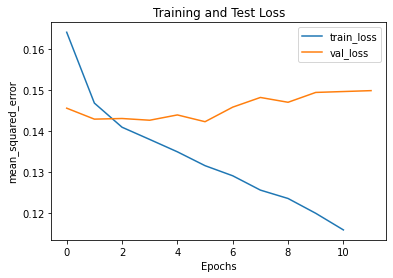

[I 2021-10-25 12:58:53,363] Trial 69 finished with value: 0.14984672872573138 and parameters: {'lr': 0.0005860464660740363, 'batch_size': 121, 'n_layers': 2, 'n_units_l0': 236, 'dropout_l0': 0.07579152463049502, 'n_units_l1': 223, 'dropout_l1': 0.0438841372802681}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:59:02,481] Trial 70 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:59:06,688] Trial 71

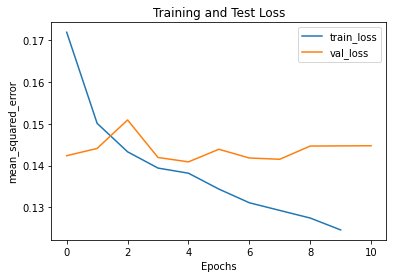

[I 2021-10-25 12:59:22,825] Trial 72 finished with value: 0.14474162459373474 and parameters: {'lr': 1.3211965534202723e-05, 'batch_size': 125, 'n_layers': 1, 'n_units_l0': 432, 'dropout_l0': 0.18742615942749746}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:59:26,888] Trial 73 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 12:59:32,162] Trial 74 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 

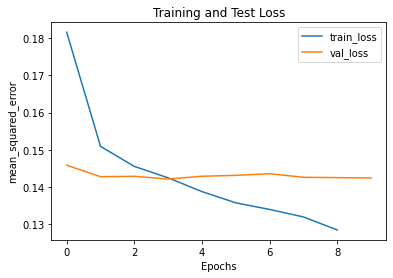

[I 2021-10-25 12:59:49,928] Trial 76 finished with value: 0.14238433566093445 and parameters: {'lr': 0.001288831677249038, 'batch_size': 128, 'n_layers': 1, 'n_units_l0': 221, 'dropout_l0': 0.11019838659115577}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 12:59:53,522] Trial 77 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 13:00:01,898] Trial 78 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 13

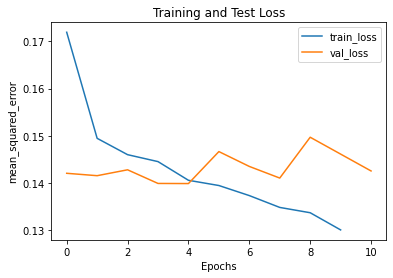

[I 2021-10-25 13:01:26,522] Trial 87 finished with value: 0.14252874779552221 and parameters: {'lr': 1.360610245579582e-05, 'batch_size': 103, 'n_layers': 3, 'n_units_l0': 173, 'dropout_l0': 0.07194883657988431, 'n_units_l1': 15, 'dropout_l1': 0.09161711158154813, 'n_units_l2': 210, 'dropout_l2': 0.07870463966706337}. Best is trial 53 with value: 0.13949080734550953.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 13:01:41,093] Trial 88 pruned. Trial was p

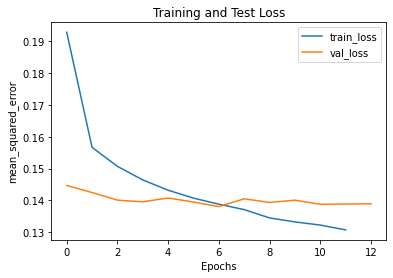

[I 2021-10-25 13:03:12,984] Trial 95 finished with value: 0.1389396020397544 and parameters: {'lr': 0.00015324890591370544, 'batch_size': 121, 'n_layers': 1, 'n_units_l0': 142, 'dropout_l0': 0.12469200035098352}. Best is trial 95 with value: 0.1389396020397544.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 13:03:31,001] Trial 96 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 13:03:50,079] Trial 97 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 13

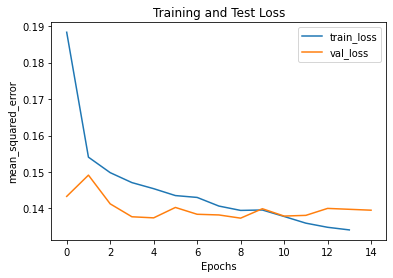

[I 2021-10-25 13:06:30,452] Trial 108 finished with value: 0.1395152049213648 and parameters: {'lr': 0.00020382186134473027, 'batch_size': 113, 'n_layers': 3, 'n_units_l0': 112, 'dropout_l0': 0.16183819305547187, 'n_units_l1': 4, 'dropout_l1': 0.06931871006553597, 'n_units_l2': 400, 'dropout_l2': 0.17105839946431592}. Best is trial 95 with value: 0.1389396020397544.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 13:06:49,035] Trial 109 pruned. Trial was p

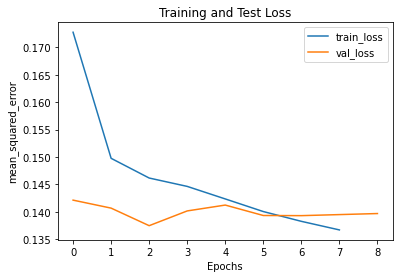

[I 2021-10-25 13:08:42,154] Trial 111 finished with value: 0.13968315697461367 and parameters: {'lr': 0.00019461616428419646, 'batch_size': 113, 'n_layers': 3, 'n_units_l0': 185, 'dropout_l0': 0.16105476961487258, 'n_units_l1': 7, 'dropout_l1': 0.01607123148679511, 'n_units_l2': 374, 'dropout_l2': 0.12090798974048314}. Best is trial 95 with value: 0.1389396020397544.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 13:09:00,349] Trial 112 pruned. Trial was 

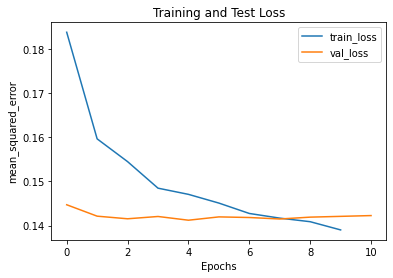

[I 2021-10-25 13:19:39,536] Trial 133 finished with value: 0.14225924407243729 and parameters: {'lr': 0.00015839952517058086, 'batch_size': 48, 'n_layers': 2, 'n_units_l0': 85, 'dropout_l0': 0.19163546422233552, 'n_units_l1': 4, 'dropout_l1': 0.029267329472767802}. Best is trial 95 with value: 0.1389396020397544.
/Users/imanwahle/anaconda2/envs/cfl_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: KerasPruningCallback has been deprecated in v2.1.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.1.0. Recent Keras release (2.4.0) simply redirects all APIs in the standalone keras package to point to tf.keras. There is now only one Keras: tf.keras. There may be some breaking changes for some workflows by upgrading to keras 2.4.0. Test before upgrading. REF:https://github.com/keras-team/keras/releases/tag/2.4.0
  
[I 2021-10-25 13:19:52,066] Trial 134 pruned. Trial was pruned at epoch 0.
[I 2021-10-25 13:20:04,324] Trial 13

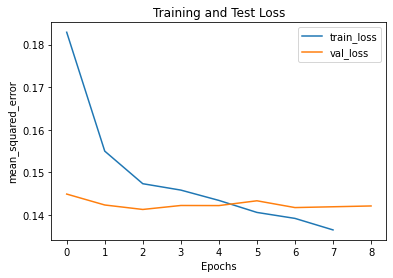

[I 2021-10-25 13:25:36,075] Trial 149 finished with value: 0.14214842402935027 and parameters: {'lr': 0.00019908343583803628, 'batch_size': 32, 'n_layers': 1, 'n_units_l0': 86, 'dropout_l0': 0.2374064684790981}. Best is trial 95 with value: 0.1389396020397544.


In [6]:
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=150)

## Print out `study` statistics and optimal hyperparameters found

In [7]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Study statistics: 
  Number of finished trials:  150
  Number of pruned trials:  123
  Number of complete trials:  27
Best trial:
  Value:  0.1389396020397544
  Params: 
    lr: 0.00015324890591370544
    batch_size: 121
    n_layers: 1
    n_units_l0: 142
    dropout_l0: 0.12469200035098352


## Rerun CFL with the optimized hyperparameters

Now, we run CFL with a CDE that is parameterized by the optimal hyperparameters 
printed out in the previous cell, and a CauseClusterer that uses the
expected conditional probability estimated in the previous step to construct
macrovariable states.

save_path 'demo_results' doesn't exist, creating now.
All results from this run will be saved to demo_results/experiment0000
#################### Beginning CFL Experiment training. ####################
Beginning CDE training...


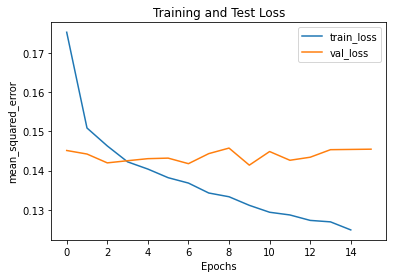

CDE training complete.
Beginning CauseClusterer training...
CauseClusterer training complete.
Experiment training complete.


In [8]:
# so our optimized model becomes:

def build_optimized_model():

    # vary number of layers
    n_layers = study.best_trial.params['n_layers']
    model = Sequential()
    for i in range(n_layers):
        # vary size of each layer
        num_hidden = study.best_trial.params[f'n_units_l{i}']
        model.add(Dense(num_hidden, activation="relu"))

        # vary amount of dropout for each layer
        dropout = study.best_trial.params[f'dropout_l{i}']
        model.add(Dropout(rate=dropout))

    # add output layer with size of target    
    model.add(Dense(Y.shape[1], activation="linear"))
    return model

data_info = {'X_dims': X.shape, 'Y_dims': Y.shape, 'Y_type': 'categorical'}

CDE_params = {
    'model'           : 'CondExpDIY',
    'build_model'     : build_optimized_model,

    'lr'              : study.best_trial.params['lr'],                
    'batch_size'      : study.best_trial.params['batch_size'],
    'n_epochs'        : 100,
    'optimizer'       : 'adam',
    'loss'            : 'mean_squared_error',
    'best'            : True, 
    'verbose'         : 0,
    'early_stopping'  : True
}

cause_cluster_params = {'model' : 'KMeans', 'n_clusters' : 4, 'verbose' : 0}

block_names = ['CondDensityEstimator', 'CauseClusterer']
block_params = [CDE_params, cause_cluster_params]

my_exp = Experiment(X_train=X, Y_train=Y, data_info=data_info, 
                    in_sample_idx=in_sample_idx, out_sample_idx=out_sample_idx,
                    block_names=block_names, block_params=block_params, 
                    results_path='demo_results')

train_results = my_exp.train()     

## Visualize the conditional probability learned by CFL with the optimized hyperparameters

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='Sample', ylabel='Expectation of Target'>)

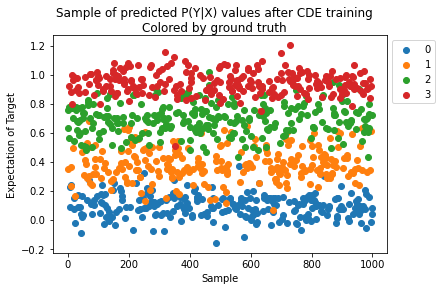

In [9]:
from cfl.visualization.cde_diagnostic import pyx_scatter
pyx_scatter(my_exp, vb_data.getGroundTruth())

## Visualize the macrovariable states that CFL finds with this set of hyperparameters

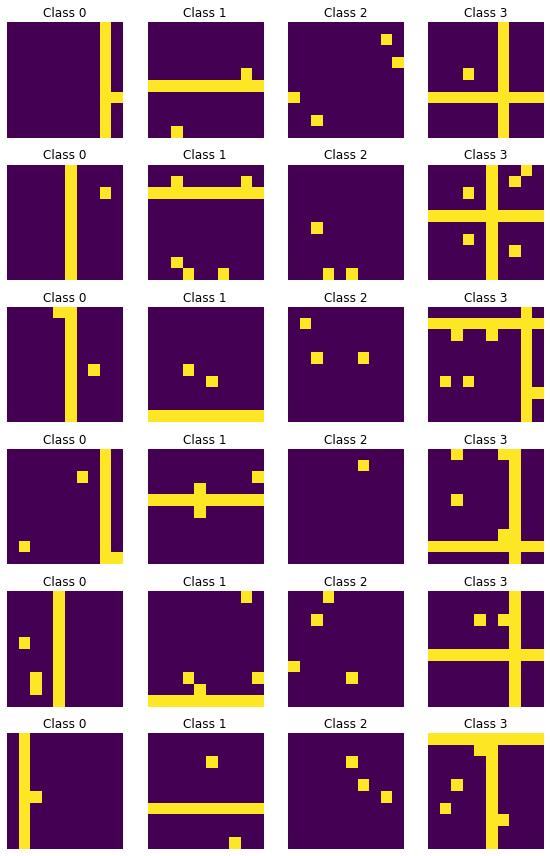

In [10]:
import visual_bars.visual_bars_vis as vis

vis.viewImagesAndLabels(X, im_shape=im_shape, n_examples=6, 
                        x_lbls=train_results['CauseClusterer']['x_lbls'])